# Chapter 30
## The PING Model of Gamma Rhythms
- Code by : [Abolfazl Ziaeemehr](https://github.com/Ziaeemehr)

In [1]:
import brian2 as b2
import matplotlib.pyplot as plt
import numpy as np


In [9]:
def plot_data(st_mon_rt, st_mon_wb, title=None, c='k'):
    """Plots the state_monitor variables "vm" vs. time.

    Args:
        state_monitor (StateMonitor): the data to plot
        title (string, optional): plot title to display
    """

    fig, ax = plt.subplots(2, figsize=(10, 6), sharex=True)

    ax[0].plot(st_mon_rt.t / b2.ms, st_mon_rt.vm[0] /
               b2.mV, lw=2, c="r", alpha=0.5, label="neuron RTM")
    ax[0].plot(st_mon_wb.t / b2.ms, st_mon_wb.vm[0] /
               b2.mV, lw=2, c="b", alpha=0.5, label='neuron WB')

    ax[1].plot(st_mon_rt.t / b2.ms, st_mon_rt.s_in[0],
               lw=2, c="r", label='s_in, source')
    ax[1].plot(st_mon_wb.t / b2.ms, st_mon_wb.s_in[0],
               lw=2, c="b", label='s_in, target')

    ax[0].set_xlabel("t [ms]")
    ax[0].set_ylabel("v [mV]")
    ax[1].set_ylabel("s")

    ax[0].set_xlim(0, np.max(st_mon_rt.t / b2.ms))
    ax[0].set_ylim(-100, 50)
    ax[1].set_ylim(0, 1)
    ax[0].legend()
    ax[1].legend()

    if title is not None:
        ax[0].set_title(title)
    
    plt.show()

In [10]:
def simulate_2_cell_PING():

    num_rt = 1
    num_wb = 1
    I_ext_rt = 1.4 * b2.uA
    I_ext_wb = 0 * b2.uA

    gSyn_rt = 0.25 * b2.msiemens
    gSyn_wb = 0.25 * b2.msiemens
    weight = 0.25       # connection weight of tr to wb cell.

    simulation_time = 200.0 * b2.ms
    integration_method = "euler"

    # RTM neuron parameters
    El = -67 * b2.mV
    EK = -100 * b2.mV
    ENa = 50 * b2.mV
    ESyn = 0 * b2.mV
    gl = 0.1 * b2.msiemens
    gK = 80 * b2.msiemens
    gNa = 100 * b2.msiemens
    C = 1 * b2.ufarad

    v0_rt = -70 * b2.mV
    v0_wb = -63 * b2.mV

    tau_d = 2 * b2.ms
    tau_r = 0.2 * b2.ms


    # forming RTM model with differential equations
    eqs_rt = """

    alphah = 0.128 * exp(-(vm + 50.0*mV) / (18.0*mV))/ms :Hz
    alpham = 0.32/mV * (vm + 54*mV) / (1.0 - exp(-(vm + 54.0*mV) / (4.0*mV)))/ms:Hz
    alphan = 0.032/mV * (vm + 52*mV) / (1.0 - exp(-(vm + 52.0*mV) / (5.0*mV)))/ms:Hz

    betah  = 4.0 / (1.0 + exp(-(vm + 27.0*mV) / (5.0*mV)))/ms:Hz
    betam  = 0.28/mV * (vm + 27.0*mV) / (exp((vm + 27.0*mV) / (5.0*mV)) - 1.0)/ms:Hz
    betan  = 0.5 * exp(-(vm + 57.0*mV) / (40.0*mV))/ms:Hz

    membrane_Im = I_ext + gNa*m**3*h*(ENa-vm) + \
        gl*(El-vm) + gK*n**4*(EK-vm) + gSyn*s_in*(-vm): amp
    I_ext : amp
    s_in  : 1
    gSyn  : siemens

    dm/dt = alpham*(1-m)-betam*m : 1
    dn/dt = alphan*(1-n)-betan*n : 1
    dh/dt = alphah*(1-h)-betah*h : 1
    
    ds/dt = 0.5 * (1 + tanh(0.1*vm/mV)) * (1-s)/tau_r - s/tau_d : 1

    dvm/dt = membrane_Im/C : volt
    """

    neuron_rt = b2.NeuronGroup(num_rt, eqs_rt, method="euler",
                               dt=0.01*b2.ms,
                               threshold='vm>-55*mV')

    # initialize variables
    neuron_rt.vm = v0_rt
    neuron_rt.m = "alpham / (alpham + betam)"
    neuron_rt.h = "alphah / (alphah + betah)"
    neuron_rt.n = "alphan / (alphan + betan)"
    neuron_rt.I_ext = I_ext_rt
    neuron_rt.s_in = 0
    neuron_rt.gSyn = gSyn_rt

    # WB neuron parameters
    El = -65 * b2.mV
    EK = -90 * b2.mV
    ENa = 55 * b2.mV
    gl = 0.1 * b2.msiemens
    gK = 9 * b2.msiemens
    gNa = 35 * b2.msiemens
    C = 1 * b2.ufarad

    tau_d = 9 * b2.ms
    tau_r = 0.5 * b2.ms

    # forming WB model with differential equations
    eqs_wb = """
    alphah = 0.35 * exp(-(vm + 58.0*mV) / (20.0*mV))/ms :Hz
    alpham = 0.1/mV * (vm + 35.0*mV) / (1.0 - exp(-0.1/mV * (vm + 35.0*mV))) /ms :Hz
    alphan = -0.05/mV * (vm + 34.0*mV) / (exp(-0.1/mV * (vm + 34.0*mV)) - 1.0)/ms :Hz
    
    betah = 5.0 / (exp(-0.1/mV * (vm + 28.0*mV)) + 1.0)/ms :Hz
    betam = 4.0 * exp(-(vm + 60.0*mV) / (18.0*mV))/ms :Hz
    betan = 0.625 * exp(-(vm + 44.0*mV) / (80.0*mV))/ms :Hz
    
    m_inf = alpham / (alpham + betam) : 1
    
    membrane_Im = I_ext + gNa*m_inf**3*h*(ENa-vm) + \
        gl*(El-vm) + gK*n**4*(EK-vm) +gSyn*s_in*(ESyn-vm): amp
    
    I_ext : amp
    s_in  : 1
    gSyn  : siemens
    
    dn/dt = alphan*(1-n)-betan*n : 1
    dh/dt = alphah*(1-h)-betah*h : 1

    ds/dt = 0.5 * (1 + tanh(0.1*vm/mV)) * (1-s)/tau_r - s/tau_d : 1
    
    dvm/dt = membrane_Im/C : volt
    """
    neuron_wb = b2.NeuronGroup(num_wb, eqs_wb, method="euler", dt=0.01*b2.ms)

    neuron_wb.vm = v0_wb
    neuron_wb.h = "alphah / (alphah + betah)"
    neuron_wb.n = "alphan / (alphan + betan)"
    neuron_wb.I_ext = I_ext_wb
    neuron_wb.s_in = 0
    neuron_wb.gSyn = gSyn_wb

    S = b2.Synapses(neuron_rt,
                    neuron_wb,
                    '''
                    w : 1
                    s_in_post = w*s_pre:1 (summed)
                    ''')
    S.connect(i=0, j=0)
    S.w[0, 0] = weight

    # tracking variables
    st_mon_rt = b2.StateMonitor(neuron_rt, ["vm", "s_in"], record=True)
    st_mon_wb = b2.StateMonitor(neuron_wb, ["vm", "s_in"], record=True)

    # running the simulation
    net = b2.Network(neuron_rt)
    net.add(neuron_wb)
    net.add(st_mon_rt)
    net.add(st_mon_wb)
    net.add(S)
    net.run(simulation_time)
    return st_mon_rt, st_mon_wb

In [11]:
st_mon_rt, st_mon_wb = simulate_2_cell_PING()

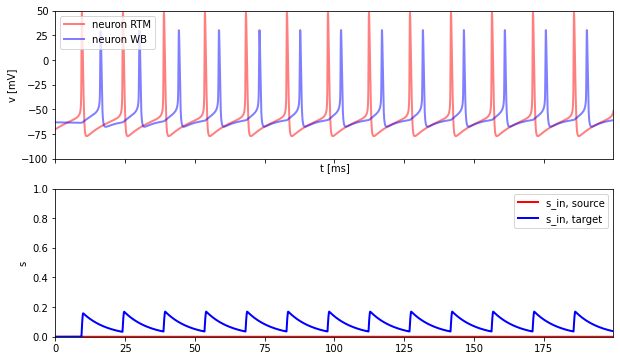

In [12]:
plot_data(st_mon_rt, st_mon_wb)